# **MASK DETECTION & SOCIAL DISTANCING DETECTION**

In [4]:
pip install retina-face

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from retinaface import RetinaFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 134MB/s] 


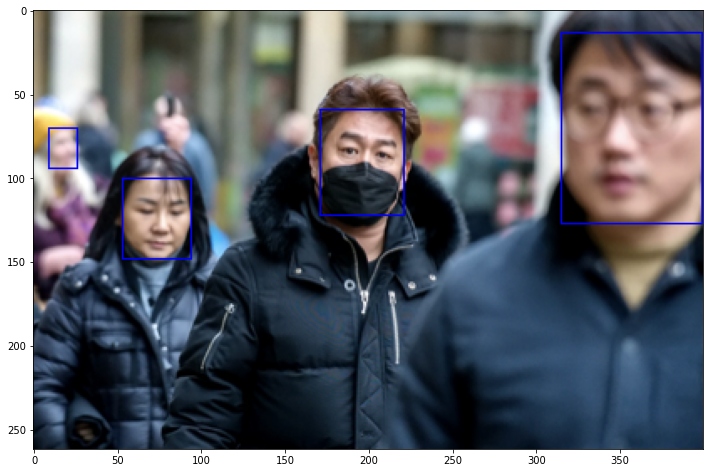

In [6]:
#trying it out on a sample image
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

faces = RetinaFace.detect_faces(img)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
for f in faces:
    identity = faces[f]
    fa = identity["facial_area"]
    cv2.rectangle(out_img,(fa[2],fa[3]),(fa[0],fa[1]),(0,0,255),1)

plt.figure(figsize=(12,12))
plt.imshow(out_img)

**Social Distancing Detection**

In [7]:
MIN_DISTANCE = 130

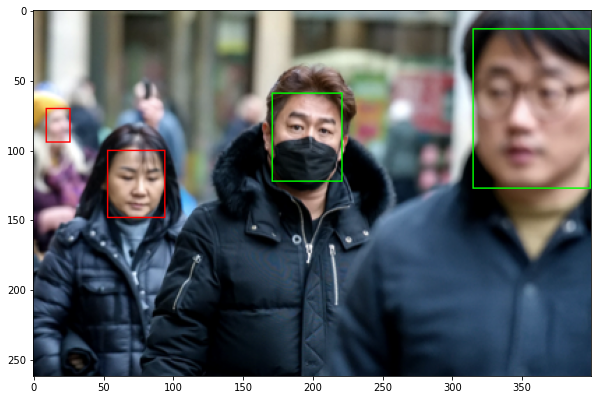

In [8]:
if len(faces)>=2:
    
    label = [0 for i in range(len(faces))]
    
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            
            fi = faces["face_" + str(i+1)]
            fj = faces["face_" + str(j+1)]
            
            fai = fi["facial_area"]
            faj = fj["facial_area"]
            
            a = np.array(fai)
            b = np.array(faj)

            dist = np.linalg.norm(a-b)
            
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
                
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
    for f in faces:
        identity = faces[f]
        fa = identity["facial_area"]
        
        i = int(f[5]) - 1
        
        if label[i]==1:
            cv2.rectangle(new_img,(fa[2],fa[3]),(fa[0],fa[1]),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(fa[2],fa[3]),(fa[0],fa[1]),(0,255,0),1)
    
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

**Mask Detection Using VGG-19**

In [9]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [10]:
#Load train and test set
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [12]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
vgg_model = Sequential()
vgg_model.add(vgg19)
vgg_model.add(Flatten())
vgg_model.add(Dense(2,activation='sigmoid'))
vgg_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [13]:
from tensorflow import keras;    
from tensorflow.keras import metrics;
import tensorflow as tf 
import tensorflow_addons as tfa

vgg_model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=2, average="micro")])

In [14]:
history = vgg_model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

Epoch 1/20
9/9 [==============================] - 35s 4s/step - loss: 0.5688 - acc: 0.6736 - precision: 0.7401 - recall: 0.5833 - f1_score: 0.6736
Epoch 2/20
9/9 [==============================] - 32s 4s/step - loss: 0.2916 - acc: 0.8750 - precision: 0.9020 - recall: 0.7986 - f1_score: 0.8750
Epoch 3/20
9/9 [==============================] - 32s 4s/step - loss: 0.1798 - acc: 0.9340 - precision: 0.9693 - recall: 0.8785 - f1_score: 0.9340
Epoch 4/20
9/9 [==============================] - 32s 4s/step - loss: 0.1231 - acc: 0.9583 - precision: 0.9742 - recall: 0.9167 - f1_score: 0.9583
Epoch 5/20
9/9 [==============================] - 32s 4s/step - loss: 0.1117 - acc: 0.9618 - precision: 0.9708 - recall: 0.9236 - f1_score: 0.9618
Epoch 6/20
9/9 [==============================] - 32s 4s/step - loss: 0.1011 - acc: 0.9688 - precision: 0.9749 - recall: 0.9444 - f1_score: 0.9688
Epoch 7/20
9/9 [==============================] - 32s 4s/step - loss: 0.0966 - acc: 0.9653 - precision: 0.9817 - recal

In [15]:
test_loss, test_acc, test_precision, test_recall, test_f1 = vgg_model.evaluate(test_generator, steps=10)

10/10 [==============================] - 36s 4s/step - loss: 0.0698 - acc: 0.9719 - precision: 0.9837 - recall: 0.9406 - f1_score: 0.9719


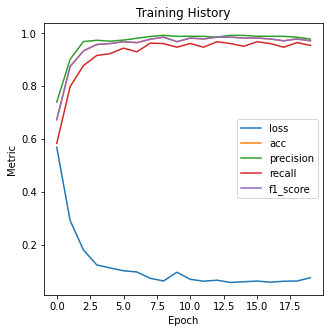

In [16]:
pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

Wearing Mask


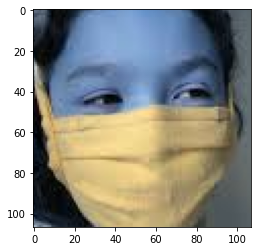

In [17]:
img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
plt.imshow(img)

img = cv2.resize(img, (128,128)) 
img = np.reshape(img, [1,128,128,3])/255.0

pred_prob = vgg_model.predict(img)[0]
pred_class = list(pred_prob).index(max(pred_prob)) 
                
if pred_class == 0:
    mask_class = "Wearing Mask"

else:
    mask_class = "Not Wearing Mask"
    
print(mask_class)

In [18]:
vgg_model.save('masknet.h5')

**Integration of Mask & Social Distancing Detection**

In [19]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [20]:
def mask_social(img):
    
    faces = RetinaFace.detect_faces(img)

    if len(faces)>=2:
    
        label = [0 for i in range(len(faces))]
    
        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
            
                fi = faces["face_" + str(i+1)]
                fj = faces["face_" + str(j+1)]
            
                fai = fi["facial_area"]
                faj = fj["facial_area"]
            
                a = np.array(fai)
                b = np.array(faj)

                dist = np.linalg.norm(a-b)
            
                if dist < MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1
                
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
        for f in faces:
            identity = faces[f]
            fa = identity["facial_area"]
        
            crop = new_img[fa[1]:fa[3],fa[0]:fa[2]]
            crop = cv2.resize(crop,(128,128))
            crop = np.reshape(crop,[1,128,128,3])/255.0
        
            mask_result = vgg_model.predict(crop)
        
            i = int(f[5]) - 1
        
            cv2.putText(new_img, mask_label[mask_result.argmax()],(fa[0], fa[1]-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],1)
            cv2.rectangle(new_img,(fa[2],fa[3]),(fa[0],fa[1]),dist_label[label[i]],1)
        
        plt.figure(figsize=(10,10))
        plt.imshow(new_img)
            
    else:
        print("No. of faces detected is less than 2 so social distancing detection isn't possible")
    
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        for f in faces:
            identity = faces[f]
            fa = identity["facial_area"]
        
            crop = new_img[fa[1]:fa[3],fa[0]:fa[2]]
            crop = cv2.resize(crop,(128,128))
            crop = np.reshape(crop,[1,128,128,3])/255.0
        
            mask_result = vgg_model.predict(crop)

            cv2.putText(new_img,mask_label[mask_result.argmax()], (fa[0], fa[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.rectangle(new_img, (fa[2],fa[3]),(fa[0],fa[1]), (255, 255, 255), 1)
    
        plt.figure(figsize=(10,10))
        plt.imshow(new_img)

In [21]:
def mask_social_integration(img, model, identities):
    
    faces = RetinaFace.detect_faces(img)
    
    if len(faces)>=2:
    
        label = [0 for i in range(len(faces))]
    
        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
            
                index_i = "face_" + str(i+1)
                index_j = "face_" + str(j+1)
                
                fi = faces[index_i]
                fj = faces[index_j]
            
                fai = fi["facial_area"]
                faj = fj["facial_area"]
            
                a = np.array(fai)
                b = np.array(faj)

                dist = np.linalg.norm(a-b)
            
                if dist < MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1
                
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
        for f in faces:
            identity = faces[f]
            fa = identity["facial_area"]
        
            crop = new_img[fa[1]:fa[3],fa[0]:fa[2]]
            crop = cv2.resize(crop,(128,128))
            crop = np.reshape(crop,[1,128,128,3])/255.0
        
            mask_result = model.predict(crop)
        
            i = int(f[5]) - 1
        
            cv2.putText(new_img, mask_label[mask_result.argmax()],(fa[0], fa[1]-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],1)
            cv2.putText(new_img, identities[i],(fa[0], fa[1]),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,78,255),1)
            cv2.rectangle(new_img,(fa[2],fa[3]),(fa[0],fa[1]),dist_label[label[i]],1)
        
        plt.figure(figsize=(10,10))
        plt.imshow(new_img)
            
    else:
        print("No. of faces detected is less than 2 so social distancing detection isn't possible")
    
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        i = 0
        
        for f in faces:
            identity = faces[f]
            fa = identity["facial_area"]
        
            crop = new_img[fa[1]:fa[3],fa[0]:fa[2]]
            crop = cv2.resize(crop,(128,128))
            crop = np.reshape(crop,[1,128,128,3])/255.0
        
            mask_result = model.predict(crop)

            cv2.putText(new_img,mask_label[mask_result.argmax()], (fa[0], fa[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.putText(new_img, identities[i],(fa[0], fa[1]),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,78,255), 1)
            cv2.rectangle(new_img, (fa[2],fa[3]),(fa[0],fa[1]),(255, 255, 255), 1)
            
            i = i + 1
    
        plt.figure(figsize=(10,10))
        plt.imshow(new_img)

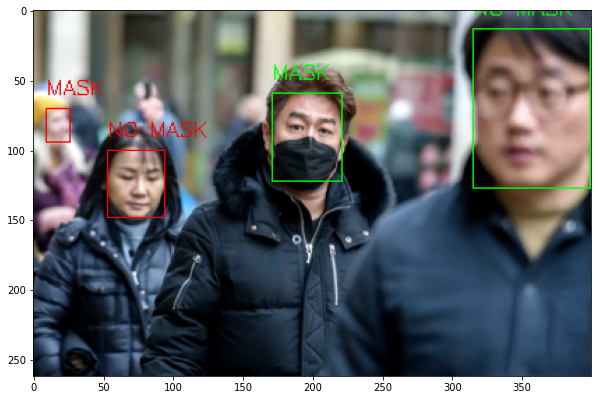

In [22]:
img1 = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')
mask_social(img1)

No. of faces detected is less than 2 so social distancing detection isn't possible


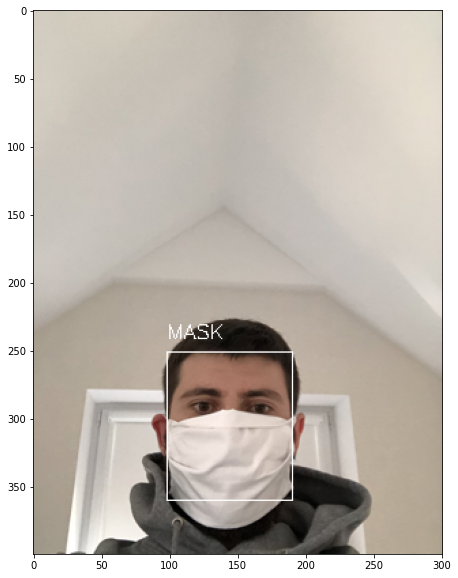

In [23]:
img2 = cv2.imread('../input/face-mask-detection/images/maksssksksss10.png')
mask_social(img2)

No. of faces detected is less than 2 so social distancing detection isn't possible


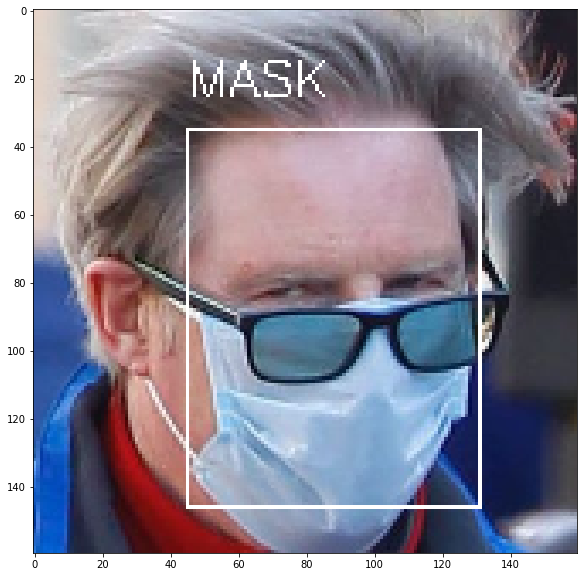

In [24]:
img3 = cv2.imread('../input/mrf-fyp/MRF_Dataset/mfr2_train/AdrianDunbar/AdrianDunbar_0001.png')
mask_social(img3)

**With ResNet-50**

In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [26]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
resnet_model = Sequential()
resnet_model.add(base_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2,activation='sigmoid'))
resnet_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 65538     
Total params: 23,653,250
Trainable params: 65,538
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
resnet_model.compile(optimizer = 'adam', loss="categorical_crossentropy",metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=2, average="micro")])

In [28]:
history_resnet = resnet_model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=50,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

Epoch 1/50
9/9 [==============================] - 14s 1s/step - loss: 0.6998 - accuracy: 0.5799 - precision_1: 0.5000 - recall_1: 1.0000 - f1_score: 0.5799
Epoch 2/50
9/9 [==============================] - 9s 949ms/step - loss: 0.6819 - accuracy: 0.5451 - precision_1: 0.5000 - recall_1: 1.0000 - f1_score: 0.5451
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 0.7104 - accuracy: 0.5347 - precision_1: 0.5026 - recall_1: 0.9896 - f1_score: 0.5347
Epoch 4/50
9/9 [==============================] - 9s 960ms/step - loss: 0.6584 - accuracy: 0.6007 - precision_1: 0.5026 - recall_1: 0.9965 - f1_score: 0.6007
Epoch 5/50
9/9 [==============================] - 9s 963ms/step - loss: 0.6496 - accuracy: 0.6181 - precision_1: 0.5017 - recall_1: 0.9965 - f1_score: 0.6181
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.6216 - accuracy: 0.6354 - precision_1: 0.5062 - recall_1: 0.9965 - f1_score: 0.6354
Epoch 7/50
9/9 [==============================] - 9s 917ms/

In [29]:
test_loss_res, test_acc_res, test_precision_res, test_recall_res, test_f1_res = resnet_model.evaluate(test_generator, steps=10)

10/10 [==============================] - 12s 962ms/step - loss: 0.4062 - accuracy: 0.8156 - precision_1: 0.5846 - recall_1: 0.9937 - f1_score: 0.8156


Not Wearing Mask


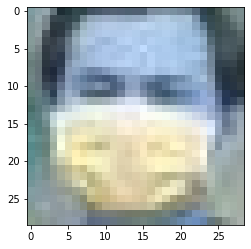

In [30]:
img_res = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1361.png')
plt.imshow(img_res)

img_res = cv2.resize(img_res, (128,128)) 
img_res = np.reshape(img_res, [1,128,128,3])/255.0

pred_prob_res = resnet_model.predict(img_res)[0]
pred_class_res = list(pred_prob_res).index(max(pred_prob_res)) 
                
if pred_class_res == 0:
    mask_class_res = "Wearing Mask"

else:
    mask_class_res = "Not Wearing Mask"
    
print(mask_class_res)

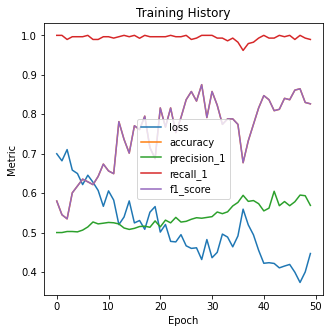

In [31]:
pd.DataFrame(history_resnet.history).plot(figsize=(5, 5))
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

**With Inceptionv3**

In [184]:
from keras.applications.inception_v3 import InceptionV3

In [185]:
base_model_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model_v3.layers:
    layer.trainable = False
    
inception_model = Sequential()
inception_model.add(base_model_v3)
inception_model.add(Flatten())
inception_model.add(Dense(2,activation='sigmoid'))
inception_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 16386     
Total params: 21,819,170
Trainable params: 16,386
Non-trainable params: 21,802,784
_________________________________________________________________


In [186]:
inception_model.compile(optimizer = 'adam', loss="categorical_crossentropy",metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=2, average="micro")])

In [ ]:
history_inception = inception_model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=15,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

Epoch 1/15
9/9 [==============================] - 12s 725ms/step - loss: 1.2296 - accuracy: 0.7153 - precision_3: 0.6732 - recall_3: 0.8368 - f1_score: 0.7153
Epoch 2/15
9/9 [==============================] - 6s 662ms/step - loss: 0.2744 - accuracy: 0.9479 - precision_3: 0.9150 - recall_3: 0.9722 - f1_score: 0.9479
Epoch 3/15
9/9 [==============================] - 7s 744ms/step - loss: 0.0949 - accuracy: 0.9757 - precision_3: 0.9500 - recall_3: 0.9896 - f1_score: 0.9757
Epoch 4/15
9/9 [==============================] - 6s 674ms/step - loss: 0.1247 - accuracy: 0.9688 - precision_3: 0.9221 - recall_3: 0.9861 - f1_score: 0.9688
Epoch 5/15
7/9 [======================>.......] - ETA: 1s - loss: 0.1123 - accuracy: 0.9866 - precision_3: 0.9652 - recall_3: 0.9911 - f1_score: 0.9866

In [36]:
test_loss_v3, test_acc_v3, test_precision_v3, test_recall_v3, test_f1_v3 = inception_model.evaluate(test_generator, steps=7)

7/7 [==============================] - 8s 643ms/step - loss: 0.0050 - accuracy: 1.0000 - precision_2: 0.9825 - recall_2: 1.0000 - f1_score: 1.0000


Wearing Mask


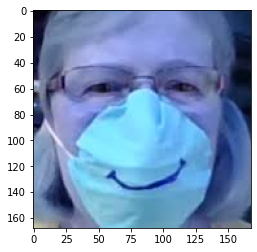

In [37]:
img_v3 = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1174.png')
plt.imshow(img_v3)

img_v3 = cv2.resize(img_v3, (128,128)) 
img_v3 = np.reshape(img_v3, [1,128,128,3])/255.0

pred_prob_v3 = inception_model.predict(img_v3)[0]
pred_class_v3 = list(pred_prob_v3).index(max(pred_prob_v3)) 
                
if pred_class_v3 == 0:
    mask_class_v3 = "Wearing Mask"

else:
    mask_class_v3 = "Not Wearing Mask"
    
print(mask_class_v3)

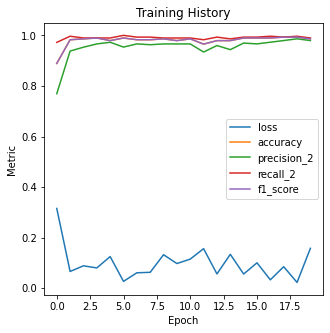

In [38]:
pd.DataFrame(history_inception.history).plot(figsize=(5, 5))
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

# **MASKED FACE RECOGNITION**

**WITH VGGFace**

In [39]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

In [40]:
import os
source_dir = os.path.join('/kaggle','input', 'mrf-fyp','MRF_Dataset','mfr2_train')

In [41]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
    
def load_metadata(path):
    metadata = []
    paths = list()
    
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            
            # Check file extension. Allow only jpg/jpeg/png' files.
            ext = os.path.splitext(f)[1]
            
            if ext == '.jpg' or ext == '.jpeg' or ext == '.png':
                metadata.append(IdentityMetadata(path, i, f))
                p = os.path.join(path, i, f)
                paths.append(p)
                
    return np.array(metadata), paths

In [42]:
# metadata = load_metadata('images')
traindata, train_paths = load_metadata(source_dir)

print('metadata shape :', traindata.shape)

metadata shape : (266,)


In [43]:
test_dir = os.path.join('/kaggle','input', 'mrf-fyp','MRF_Dataset','mrf2_test')

testdata, test_paths = load_metadata(test_dir)

In [44]:
import cv2

def load_image(path):
    img = cv2.imread(path, 1)
    
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [46]:
vggface = vgg_face()

vggface.load_weights('../input/vggface/vgg_face_weights.h5')

In [47]:
vggface.layers[0], vggface.layers[-2]

(<keras.layers.convolutional.ZeroPadding2D at 0x7f25b3b695d0>,
 <keras.layers.core.Flatten at 0x7f25b3aa4fd0>)

In [48]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=vggface.layers[0].input, outputs=vggface.layers[-2].output)

In [49]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = traindata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [50]:
def get_embeddings(model, data):
    embeddings = np.zeros((data.shape[0], 2622))
    
    for i, m in enumerate(data):
        img_path = data[i].image_path()
        
        image = load_image(img_path)
        faces = RetinaFace.detect_faces(image)
        
        for f in faces:
                
            if isinstance(f, str):
                identity = faces[f]
                fa = identity["facial_area"]
    
                crop = image[fa[1]:fa[3],fa[0]:fa[2]]
                crop = cv2.resize(crop,(224,224))
           
                embedding_vector = model.predict(np.expand_dims(crop, axis=0))[0]
                embeddings[i] = embedding_vector
                
            else:
                img = (image / 255.).astype(np.float32)
                img = cv2.resize(img, dsize = (224, 224))
                         
                embedding_vector = model.predict(np.expand_dims(img, axis=0))[0]
                embeddings[i] = embedding_vector
    
    return embeddings

In [51]:
train_embeddings = get_embeddings(vgg_face_descriptor, traindata)
train_embeddings 

array([[ 6.02856874, -0.68413985, -1.37613785, ...,  1.80888283,
         2.80867028, -1.30019975],
       [ 3.19263411,  2.23762059, -0.04238592, ..., -0.78682452,
         1.58570921, -1.38620067],
       [ 2.75693369,  2.61552835,  0.52316779, ...,  1.51627171,
         2.0029304 , -0.95507926],
       ...,
       [ 5.9649601 , -1.70725703,  1.33178961, ..., -6.20984983,
        -0.78405637,  3.01314807],
       [ 2.20925355,  2.43596911, -1.1531359 , ..., -4.11052322,
         1.90425086,  2.81046963],
       [ 2.05452681,  2.33355832,  0.60339737, ..., -1.15672314,
         2.7759583 ,  5.62910128]])

In [52]:
test_embeddings = get_embeddings(vgg_face_descriptor, testdata)

In [53]:
X_train = train_embeddings
X_test = test_embeddings

y_train = np.array([m.name for m in traindata])
y_test = np.array([t.name for t in testdata])

In [54]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (266,2622)
y_train shape : (266,)
X_test shape : (207,2622)
y_test shape : (207,)


In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [56]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [57]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (266,2622)
y_train_encoded shape : (266,)
X_test_std shape : (207,2622)
y_test_encoded shape : (207,)


In [155]:
from sklearn.decomposition import PCA

pca = PCA(n_components=114)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [157]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0003, 0.0005, 0.001, 0.0001, 0.001, 0.01], 'kernel':('linear', 'rbf')
          }

svc = SVC()

clf = GridSearchCV(svc, param_grid)
clf.fit(X_train_pca, y_train_encoded)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0003, 0.0005, 0.001, 0.0001, 0.001, 0.01],
                         'kernel': ('linear', 'rbf')})

In [158]:
y_predict = clf.predict(X_test_pca)

In [159]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.7536231884057971

In [62]:
mrf_accuracies = {}
mrf_vggface = accuracy_score(y_test_encoded, y_predict)
mrf_accuracies['VGGFace'] = mrf_vggface

Expected Identity: DennyTamaki
Predicted Identity: DennyTamaki


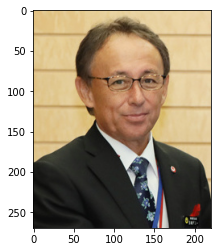

In [63]:
example_idx = 3

example_image = load_image(testdata[example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_test[example_idx]
expected = y_test[example_idx]

plt.imshow(example_image)
print('Expected Identity: %s' % expected)
print('Predicted Identity: %s' % example_identity)

Expected Identity: TakeOff
Predicted Identity: TakeOff


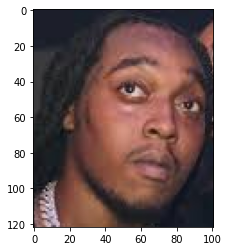

In [64]:
example_idx = 82

example_image = load_image(testdata[example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_test[example_idx]
expected = y_test[example_idx]

plt.imshow(example_image)
print('Expected Identity: %s' % expected)
print('Predicted Identity: %s' % example_identity)

Expected Identity: RalphNortham
Predicted Identity: RalphNortham


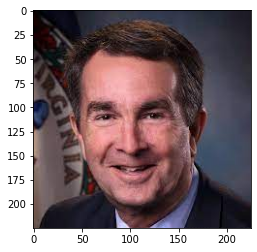

In [65]:
example_idx = 54

example_image = load_image(testdata[example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_test[example_idx]
expected = y_test[example_idx]

plt.imshow(example_image)
print('Expected Identity: %s' % expected)
print('Predicted Identity: %s' % example_identity)

In [66]:
target_names = ['AdrianDunbar', 'AhmadAli', 'ArifAlvi', 'BellaHadid', 'BenAffleck',
       'BrianKemp', 'BrodyJenner', 'CarrieLam', 'CharlieBaker',
       'DennyTamaki', 'DonnellRawlings', 'DougDucey', 'EmmanuelMacron',
       'EricGarcetti', 'FloydMayweather', 'GaryHerbert', 'GavinNewsom',
       'GretchenWhitmer', 'IgorMatovic', 'ImranKhan', 'JaredPolis',
       'JoeBiden', 'JonathanBennet', 'JustinTrudeau', 'KimKardashian',
       'KyriakosMitsotakis', 'LadyGaga', 'LarryHogan', 'MatthewMorrison',
       'MikeDewine', 'MitchMcConnell', 'MuhammadFahmi', 'NancyPelosi',
       'PharrellWilliams', 'PhilMurphy', 'RalphNortham', 'ReneeMorrison',
       'RonDesantis', 'RoyCooper', 'SimonCowell', 'SteveHarvey',
       'StevenReed', 'TakeOff', 'TaroKono', 'TomWolf', 'TsaiIngwen',
       'UddhavThackery', 'VassilisKikilias', 'XiJinping', 'YoshihideSuga',
       'YurikoKoike', 'ZacEfron', 'ZuzanaCaputova']

<function matplotlib.pyplot.show(close=None, block=None)>

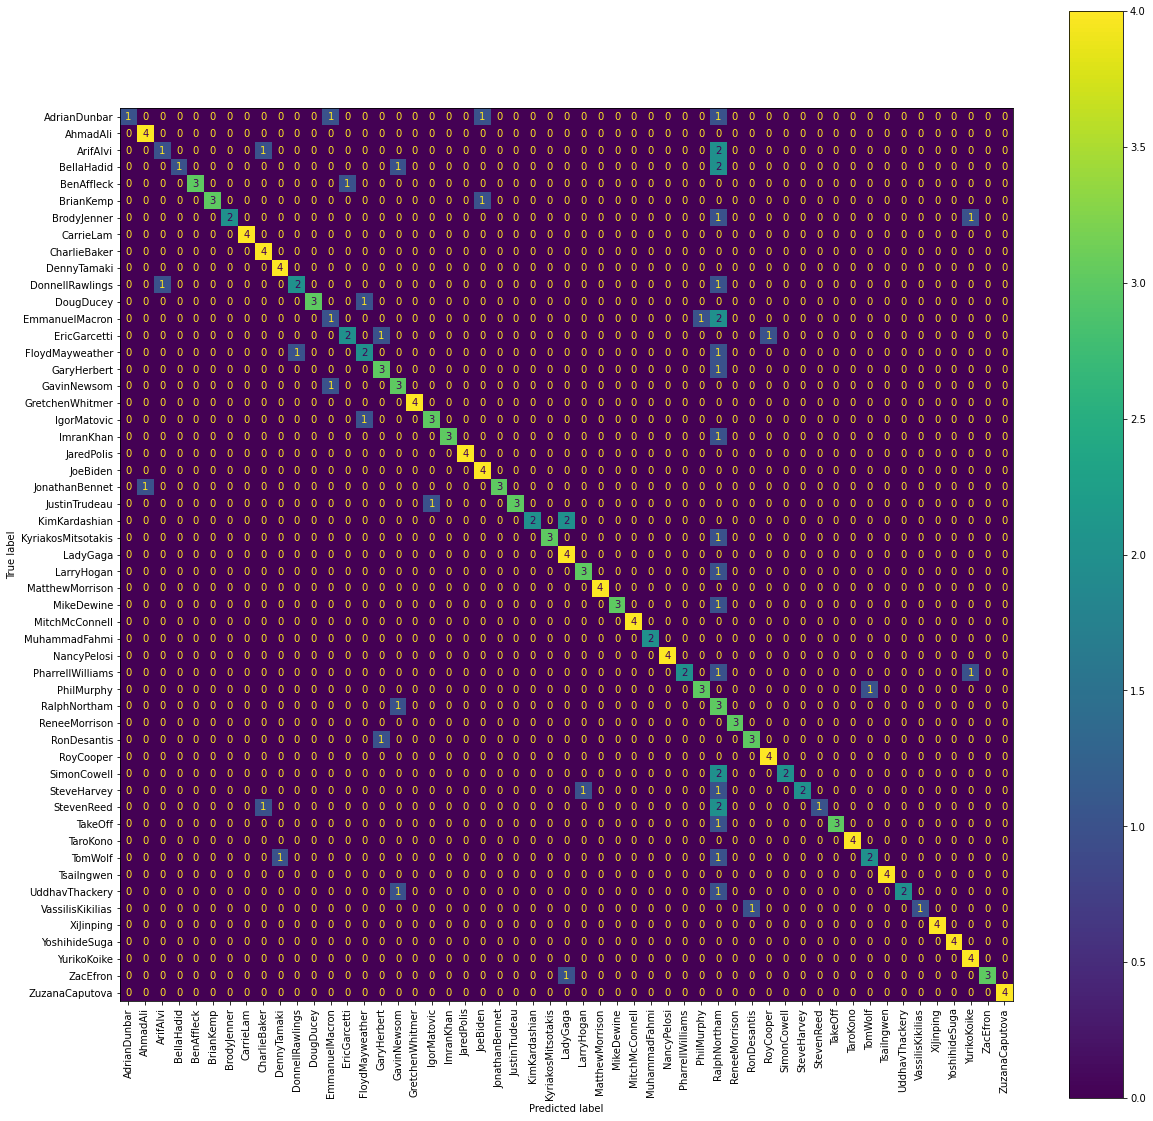

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test_encoded, display_labels=target_names, xticks_rotation="vertical"
)

plt.gcf().set_size_inches(20,20)
plt.show

In [68]:
from sklearn.metrics import classification_report

print("Predicting people's names on the test set")
print(classification_report(y_test_encoded,y_predict,target_names= target_names))

Predicting people's names on the test set
                    precision    recall  f1-score   support

      AdrianDunbar       1.00      0.25      0.40         4
          AhmadAli       0.80      1.00      0.89         4
          ArifAlvi       0.50      0.25      0.33         4
        BellaHadid       1.00      0.25      0.40         4
        BenAffleck       1.00      0.75      0.86         4
         BrianKemp       1.00      0.75      0.86         4
       BrodyJenner       1.00      0.50      0.67         4
         CarrieLam       1.00      1.00      1.00         4
      CharlieBaker       0.67      1.00      0.80         4
       DennyTamaki       0.80      1.00      0.89         4
   DonnellRawlings       0.67      0.50      0.57         4
         DougDucey       1.00      0.75      0.86         4
    EmmanuelMacron       0.33      0.25      0.29         4
      EricGarcetti       0.67      0.50      0.57         4
   FloydMayweather       0.50      0.50      0.50        

**WITH FACENET**

In [69]:
from keras.models import load_model
facenet_model = load_model('../input/facenet/keras-facenet/model/facenet_keras.h5')

In [70]:
def get_embeddings_fn(model, data):
    embeddings = np.zeros((data.shape[0], 128))
    
    for i, m in enumerate(data):
        img_path = data[i].image_path()
        img = load_image(img_path)
        img = (img / 255.).astype(np.float32)
        img = cv2.resize(img, dsize = (160,160))
    
        embedding_vector = model.predict(np.expand_dims(img, axis=0))[0]
        embeddings[i] = embedding_vector
    
    return embeddings

In [71]:
train_embeddings_fn = get_embeddings_fn(facenet_model, traindata)
test_embeddings_fn = get_embeddings_fn(facenet_model, testdata)

In [72]:
X_train_fn = train_embeddings_fn
X_test_fn = test_embeddings_fn

y_train_fn = np.array([m.name for m in traindata])
y_test_fn = np.array([t.name for t in testdata])

In [73]:
from sklearn.preprocessing import LabelEncoder

le_fn = LabelEncoder()
y_train_encoded_fn = le_fn.fit_transform(y_train_fn)
y_test_encoded_fn = le_fn.transform(y_test_fn)

In [74]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler_fn = StandardScaler()
X_train_std_fn = scaler_fn.fit_transform(X_train_fn)
X_test_std_fn = scaler_fn.transform(X_test_fn)

In [176]:
from sklearn.decomposition import PCA

pca_fn = PCA(n_components=80)
X_train_pca_fn = pca_fn.fit_transform(X_train_std_fn)
X_test_pca_fn = pca_fn.transform(X_test_std_fn)

In [177]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid_fn = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.003, 0.005, 0.001, 0.005, 0.0001, 0.001], 'kernel':('linear', 'rbf')
          }

svc_fn = SVC()

clf_fn = GridSearchCV(svc_fn, param_grid_fn)
clf_fn.fit(X_train_pca_fn, y_train_encoded_fn)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.003, 0.005, 0.001, 0.005, 0.0001, 0.001],
                         'kernel': ('linear', 'rbf')})

In [178]:
y_predict_fn = clf_fn.predict(X_test_pca_fn)

In [179]:
# Find the classification accuracy
accuracy_score(y_test_encoded_fn, y_predict_fn)

0.40096618357487923

In [79]:
mrf_facenet = accuracy_score(y_test_encoded_fn, y_predict_fn)
mrf_accuracies['FaceNet'] = mrf_facenet

In [80]:
from sklearn.metrics import classification_report

print("Predicting people's names on the test set")
print(classification_report(y_test_encoded_fn,y_predict_fn,target_names= target_names))

Predicting people's names on the test set
                    precision    recall  f1-score   support

      AdrianDunbar       0.00      0.00      0.00         4
          AhmadAli       0.67      0.50      0.57         4
          ArifAlvi       0.17      0.25      0.20         4
        BellaHadid       1.00      0.25      0.40         4
        BenAffleck       1.00      0.25      0.40         4
         BrianKemp       0.00      0.00      0.00         4
       BrodyJenner       0.00      0.00      0.00         4
         CarrieLam       0.00      0.00      0.00         4
      CharlieBaker       0.17      0.25      0.20         4
       DennyTamaki       1.00      0.50      0.67         4
   DonnellRawlings       1.00      0.75      0.86         4
         DougDucey       0.06      0.25      0.10         4
    EmmanuelMacron       0.75      0.75      0.75         4
      EricGarcetti       0.00      0.00      0.00         4
   FloydMayweather       1.00      0.25      0.40        

Expected Identity: StevenReed
Predicted Identity: StevenReed


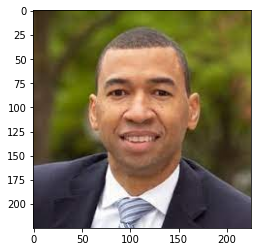

In [81]:
example_idx = 11

example_image = load_image(testdata[example_idx].image_path())
example_prediction = y_predict_fn[example_idx]
example_identity =  y_test_fn[example_idx]
expected = y_test_fn[example_idx]

plt.imshow(example_image)
print('Expected Identity: %s' % expected)
print('Predicted Identity: %s' % example_identity)

**WITH ARCFACE**

In [82]:
pip install DeepFace

     |████████████████████████████████| 63 kB 1.2 MB/s             
     |████████████████████████████████| 2.3 MB 8.9 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [83]:
from deepface import DeepFace
arc_model = DeepFace.build_model('ArcFace')

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 122MB/s] 


In [84]:
arc_model.load_weights('../input/pretrained-models/arcface_weights.h5')

In [85]:
def get_embeddings_arc(model, data):
    embeddings = np.zeros((data.shape[0], 512))
    
    for i, m in enumerate(data):
        img_path = data[i].image_path()
        img = load_image(img_path)
        img = (img / 255.).astype(np.float32)
        img = cv2.resize(img, dsize = (112,112))
    
        embedding_vector = model.predict(np.expand_dims(img, axis=0))[0]
        embeddings[i] = embedding_vector
    
    return embeddings

In [86]:
train_embeddings_arc = get_embeddings_arc(arc_model, traindata)
test_embeddings_arc = get_embeddings_arc(arc_model, testdata)

In [87]:
X_train_arc = train_embeddings_arc
X_test_arc = test_embeddings_arc

y_train_arc = np.array([m.name for m in traindata])
y_test_arc = np.array([t.name for t in testdata])

In [88]:
from sklearn.preprocessing import LabelEncoder

le_arc = LabelEncoder()
y_train_encoded_arc = le_arc.fit_transform(y_train_arc)
y_test_encoded_arc = le_arc.transform(y_test_arc)

In [89]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler_arc = StandardScaler()
X_train_std_arc = scaler_arc.fit_transform(X_train_arc)
X_test_std_arc = scaler_arc.transform(X_test_arc)

In [180]:
from sklearn.decomposition import PCA

pca_arc = PCA(n_components=108)
X_train_pca_arc= pca_arc.fit_transform(X_train_std_arc)
X_test_pca_arc = pca_arc.transform(X_test_std_arc)

In [181]:
param_grid_arc = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0003, 0.0005, 0.001, 0.005, 0.001, 0.001], 'kernel':('linear', 'rbf')
          }

svc_arc = SVC()

clf_arc = GridSearchCV(svc_arc, param_grid_arc)
clf_arc.fit(X_train_pca_arc, y_train_encoded_arc)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0003, 0.0005, 0.001, 0.005, 0.001, 0.001],
                         'kernel': ('linear', 'rbf')})

In [182]:
y_predict_arc = clf_arc.predict(X_test_pca_arc)

In [183]:
# Find the classification accuracy
accuracy_score(y_test_encoded_arc, y_predict_arc)

0.2463768115942029

In [94]:
mrf_arcface = accuracy_score(y_test_encoded_arc, y_predict_arc)
mrf_accuracies['ArcFace'] = mrf_arcface

In [95]:
from sklearn.metrics import classification_report

print("Predicting people's names on the test set")
print(classification_report(y_test_encoded_arc,y_predict_arc,target_names=target_names))

Predicting people's names on the test set
                    precision    recall  f1-score   support

      AdrianDunbar       0.00      0.00      0.00         4
          AhmadAli       0.33      0.25      0.29         4
          ArifAlvi       0.67      0.50      0.57         4
        BellaHadid       0.00      0.00      0.00         4
        BenAffleck       0.33      0.25      0.29         4
         BrianKemp       0.00      0.00      0.00         4
       BrodyJenner       0.00      0.00      0.00         4
         CarrieLam       1.00      0.25      0.40         4
      CharlieBaker       0.00      0.00      0.00         4
       DennyTamaki       0.00      0.00      0.00         4
   DonnellRawlings       0.00      0.00      0.00         4
         DougDucey       0.00      0.00      0.00         4
    EmmanuelMacron       0.75      0.75      0.75         4
      EricGarcetti       0.00      0.00      0.00         4
   FloydMayweather       0.00      0.00      0.00        

Expected Identity: MuhammadFahmi
Predicted Identity: MuhammadFahmi


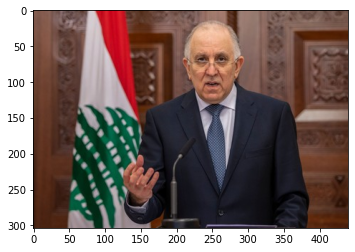

In [96]:
example_idx = 13

example_image = load_image(testdata[example_idx].image_path())
example_prediction = y_predict_arc[example_idx]
example_identity =  y_test_arc[example_idx]
expected = y_test_arc[example_idx]

plt.imshow(example_image)
print('Expected Identity: %s' % expected)
print('Predicted Identity: %s' % example_identity)

# **Integration**

In [97]:
def integration(img_path):
    
    identities = []
    
    image = load_image(img_path)
    faces = RetinaFace.detect_faces(image)
    
    for f in faces:
            identity = faces[f]
            fa = identity["facial_area"]
        
            crop = image[fa[1]:fa[3],fa[0]:fa[2]]
            crop = cv2.resize(crop,(224,224))
           
            embedding_vector = vgg_face_descriptor.predict(np.expand_dims(crop, axis=0))[0]
    
            embedding_vector = embedding_vector.reshape(1, -1)
            scaled = scaler.transform(embedding_vector)
    
            transform = pca.transform(scaled)
    
            y_predict = clf.predict(transform)
    
            result = le.inverse_transform(y_predict)
        
            identities.append(result[0])
    
    pic = cv2.imread(img_path)
    mask_social_integration(pic, vgg_model, identities)

No. of faces detected is less than 2 so social distancing detection isn't possible


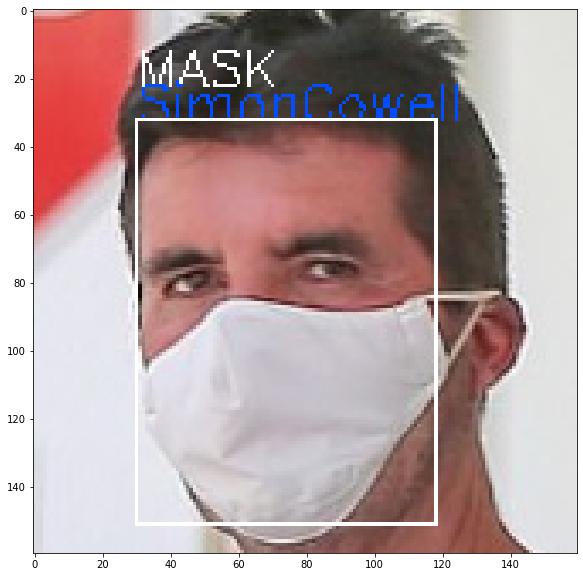

In [98]:
integration('../input/mrf-fyp/MRF_Dataset/mfr2_train/SimonCowell/SimonCowell_0001.png')

In [99]:
integration('../input/fyp-joe-justin/joe_justin.jpg')

TypeError: 'NoneType' object is not subscriptable

**COMPARISION AND GRAPHS**

In [ ]:
mrf_accuracies

In [ ]:
names = list(mrf_accuracies.keys())
values = list(mrf_accuracies.values())

plt.bar(range(len(mrf_accuracies)), values, tick_label=names)
plt.show()